# PREPARE DATASET FOR PNOI EXPERIMENTS

In [1]:
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import librosa
import os

mkdir = lambda p: 0 if os.path.exists(p) else (os.mkdir(p), 1)[1]

## PATHS to dataset

In [2]:
REPORTS = "reports"; mkdir(REPORTS) # Path to the reports folder

PNOI_CORPUS_CSV_NAME = "pnoicorpus_muster.csv" # Name of the csv file

PNOI_CORPUS_CSV_PATH = f"{REPORTS}/{PNOI_CORPUS_CSV_NAME}" # Path to the master csv file

## FILTER dataset

In [3]:
class DataFilter:

    EMPTY_VAL = '-'
    PNOI_MUSTER_DF: pd.DataFrame

    FILTER_DATA_CSV_FNAME = "filtered_dataset.csv"

    PNOI_FILT_DF: pd.DataFrame

    def __init__(self, muster_csv_path: str) -> None:
        pnoi_corpus_DF = pd.read_csv(muster_csv_path)
        pnoi_corpus_DF.columns = pnoi_corpus_DF.columns.str.replace("--file_path", "")

        self.PNOI_MUSTER_DF: pd.DataFrame = pnoi_corpus_DF

        self.PNOI_FILT_DF: pd.DataFrame = self.filter_df()

    def filter_df(self):
        # BREATH AUDIO (BA) Columns
        col_str_match = r"anot--LBA_before|anot--VBA_before" # match string
        ba_cols = self.PNOI_MUSTER_DF.columns[self.PNOI_MUSTER_DF.columns.str.contains(col_str_match)] # get columns that match string
        filts = [self.PNOI_MUSTER_DF[col] != self.EMPTY_VAL for col in ba_cols] # filters for non-empty values
        filt = functools.reduce(lambda p, c: p & c, filts) # combine filters

        pnoi_corpus_filt_DF = self.PNOI_MUSTER_DF[filt] # apply filter
        pnoi_corpus_filt_DF.to_csv(f"{REPORTS}/{self.FILTER_DATA_CSV_FNAME}") # save filtered dataframe to csv
        print(pnoi_corpus_filt_DF.shape)
        
        return pnoi_corpus_filt_DF
    
pnoidata_filter = DataFilter(PNOI_CORPUS_CSV_PATH)

pnoidata_filter.PNOI_FILT_DF.head()

(25, 47)


,index,app_code,sub_id,subjectName,subjectGender,subjectAge,subjectType,subjectHeight,subjectWeight,META,...,LBA_after_RU,anot--LBA_after_RU,LBA_after_LL,anot--LBA_after_LL,LBA_after_RL,anot--LBA_after_RL,PFT_before,anot--PFT_before,PFT_after,anot--PFT_after
0,0,pnoistor_feb2023,shreyamgupta_78aa423a,Shreyam Gupta,Female,19,Control,158,70,DATA_PNOISTOR/pnoistor_feb2023/shreyamgupta_78...,...,-,-,-,-,-,-,DATA_PNOISTOR/pnoistor_feb2023/shreyamgupta_78...,DATA_PNOISTOR/pnoistor_feb2023/shreyamgupta_78...,-,-
2,2,pnoistor_dec01,sannashoukat_5213fe84,Sanna Shoukat,Female,21,Control,166,55,DATA_PNOISTOR/pnoistor_dec01/sannashoukat_5213...,...,-,-,-,-,-,-,DATA_PNOISTOR/pnoistor_dec01/sannashoukat_5213...,DATA_PNOISTOR/pnoistor_dec01/sannashoukat_5213...,-,-
3,3,pnoistor_feb2023,sananaushad_80e84b51,Sana Naushad,Female,21,Control,158,60,DATA_PNOISTOR/pnoistor_feb2023/sananaushad_80e...,...,-,-,-,-,-,-,DATA_PNOISTOR/pnoistor_feb2023/sananaushad_80e...,DATA_PNOISTOR/pnoistor_feb2023/sananaushad_80e...,-,-
4,4,pnoistor_dec01,saikeerthanaarun_3364bc1a,Sai Keerthana Arun,Female,22,Control,172,58,DATA_PNOISTOR/pnoistor_dec01/saikeerthanaarun_...,...,-,-,-,-,-,-,-,-,-,-
6,6,pnoistor_dec01,kumarchowdam_53f32e31,Kumar Chowdam,Male,21,Control,162,60,DATA_PNOISTOR/pnoistor_dec01/kumarchowdam_53f3...,...,-,-,-,-,-,-,DATA_PNOISTOR/pnoistor_dec01/kumarchowdam_53f3...,DATA_PNOISTOR/pnoistor_dec01/kumarchowdam_53f3...,-,-


In [4]:
import soundfile as sf

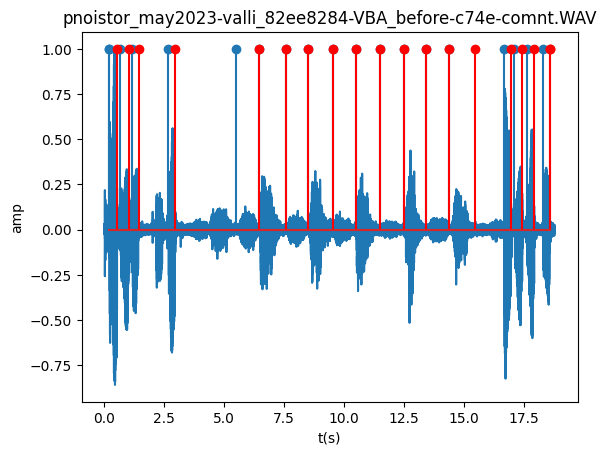

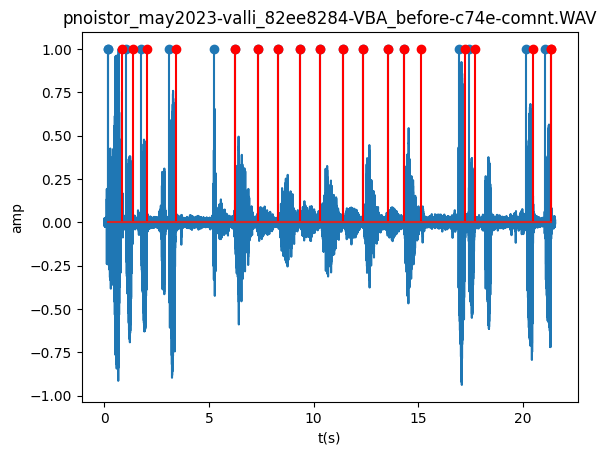

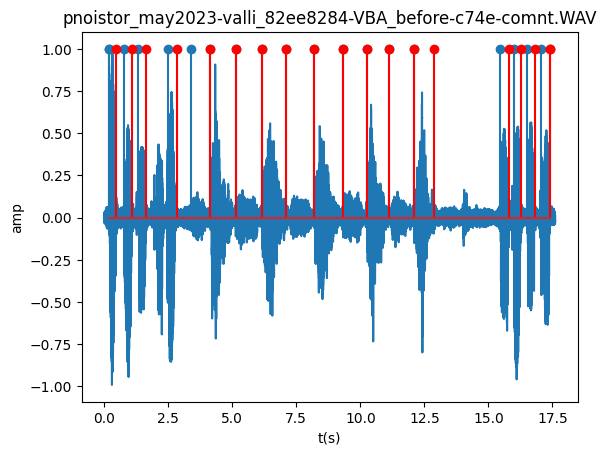

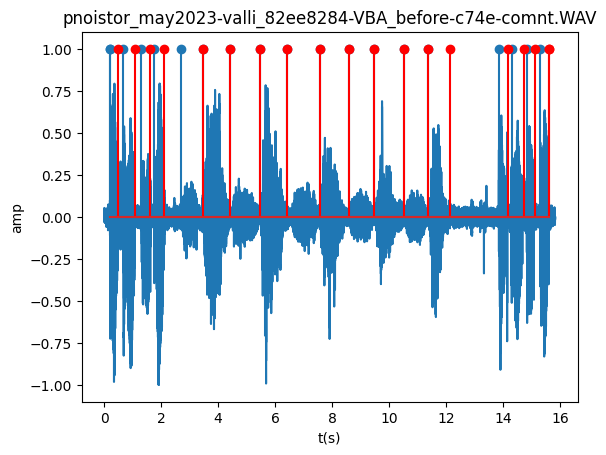

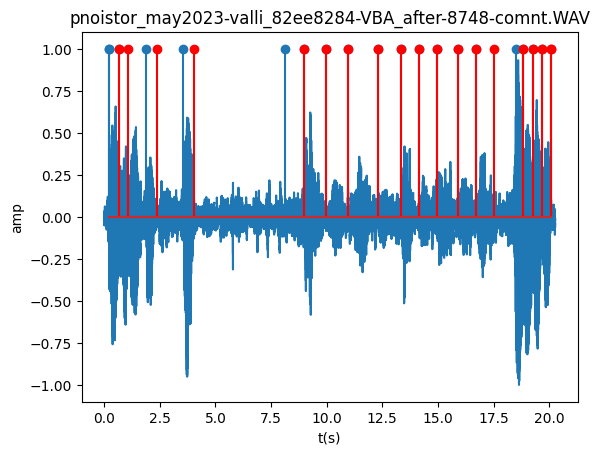

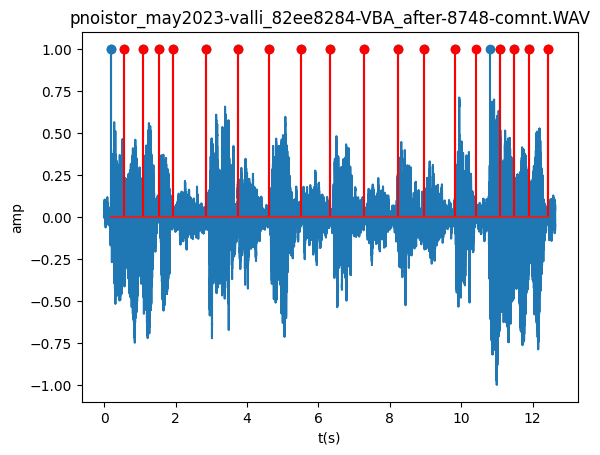

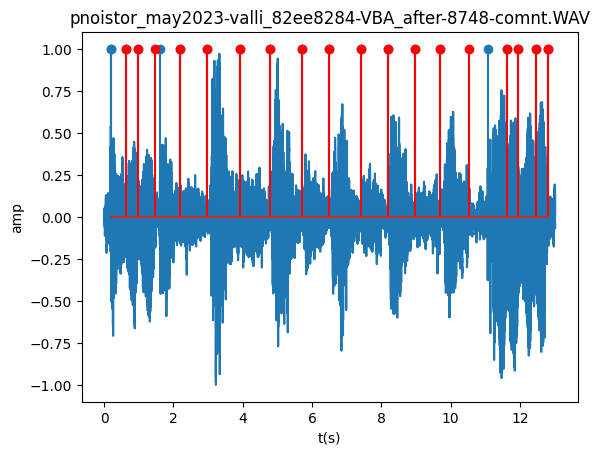

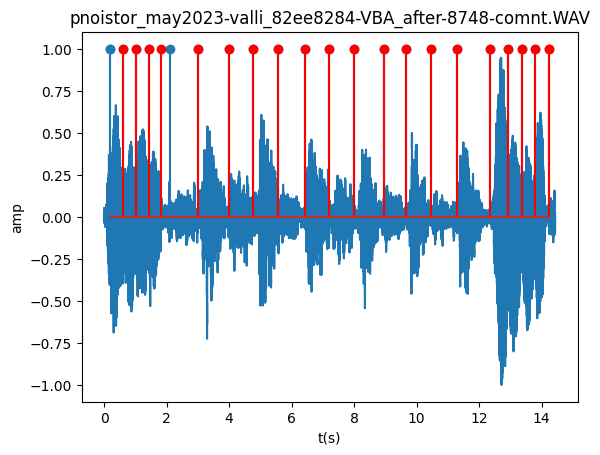

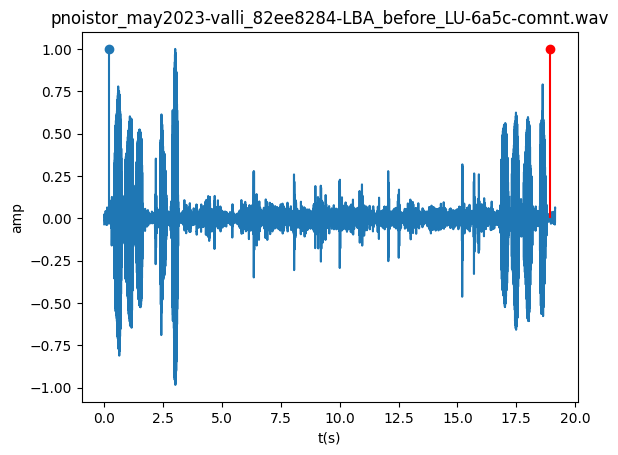

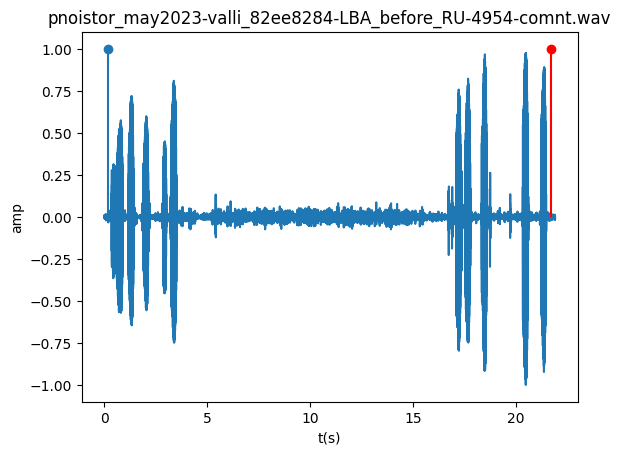

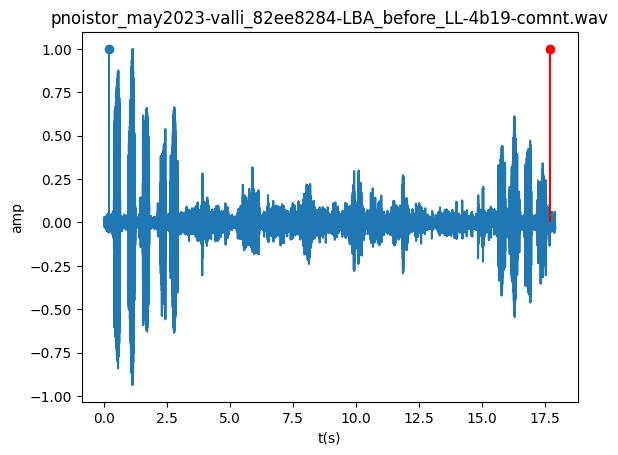

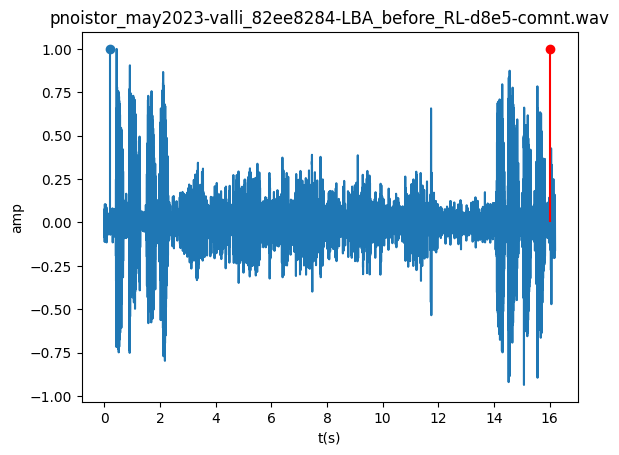

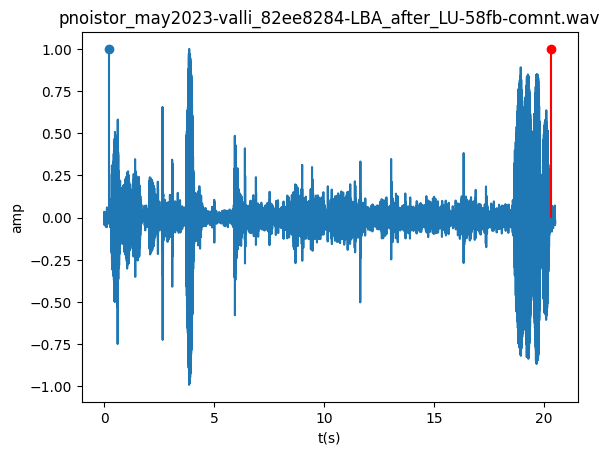

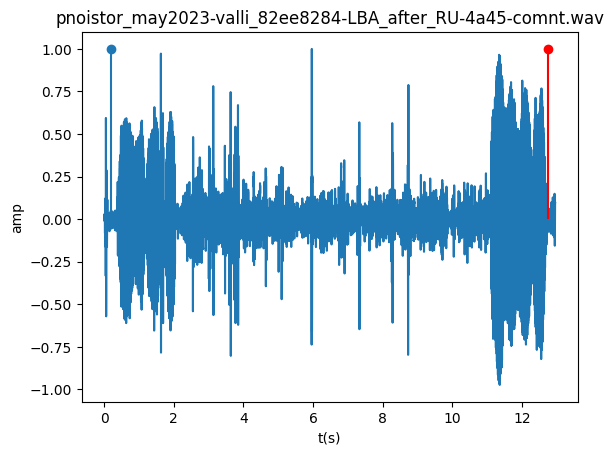

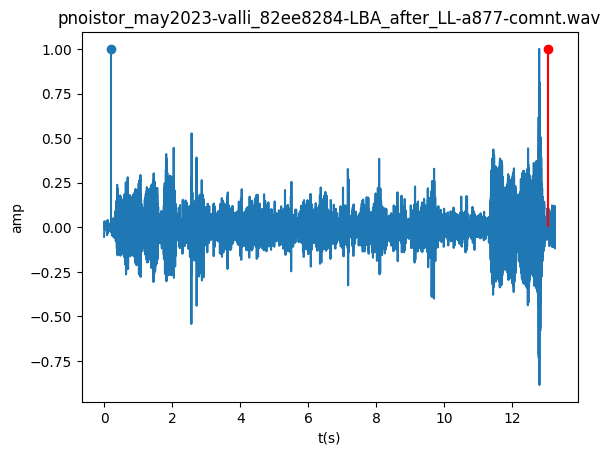

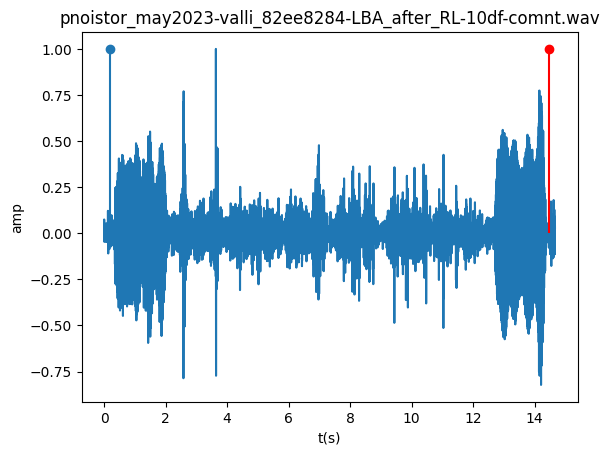

{'fs': 4000,
 'audio_fpath': 'DATA_PNOISTOR/pnoistor_may2023/valli_82ee8284/pnoistor_may2023-valli_82ee8284-LBA_after_RL-10df-comnt.wav',
 'signal': array([0.00782918, 0.01637011, 0.02562278, ..., 0.01992883, 0.02491103,
        0.03060498], dtype=float32),
 'label_df':    begin        end label
 0    0.2  14.459378   bb4}

In [16]:
class AudioDataProcess:

    DRY_RUN = False
    EMPTY_VAL = '-'
    FNAME_SEP = "-"
    ANOTE_SEP = '\t'
    BEGIN = "begin"; END = "end"; LABEL = "label"
    ANOTE_COLS = [BEGIN, END, LABEL]

    LUNG_LOCS = ["LU", "LL", "RL", "RU"]
    GAP = "gap"
    GAP_DUR = 10.0
    PAD_DUR = 0.2
    DURATION = "duration"
    AUDIO_FPATH = "audio_fpath"

    FS = "fs"
    SIGNAL = "signal"
    LABEL_DF = "label_df"
    EXPORT_FOLDER = "data_export"
    
    PNOI_FILT_DF: pd.DataFrame
    
    def __init__(self, data_df: pd.DataFrame) -> None:
        self.PNOI_FILT_DF = data_df


    def anot_breath_loc_chunks(self, audio_fp: str, anot_fp: str) -> list[pd.DataFrame]:
        """
        Split audio file into chunks based on duration b/w breaths in the audio file.
        The breaths are annotated in the annotation file.
        The annotation file is a tsv file exported from audacity.
        """

        anot_df: pd.DataFrame = pd.read_csv(anot_fp, sep=self.ANOTE_SEP, names=self.ANOTE_COLS) 
        # Read annotation labeled with audacity tsv file

        anot_df[self.AUDIO_FPATH] = audio_fp
        anot_df[self.DURATION] = anot_df[self.END] - anot_df[self.BEGIN] 
        # Calculate duration of each label marke in annotation

        anot_df[self.GAP] = anot_df[self.BEGIN].shift(-1) - anot_df[self.END] 
        # Calculate gap between previous label end and next label start: give the gap between labels

        gap_filt = (anot_df[self.GAP] > self.GAP_DUR) | (anot_df[self.GAP].isnull()) 
        # Filter rows where gap b/w labels is above the threshold (GAP)
        anot_gap_df = anot_df.loc[gap_filt] # Apply filter

        i_splits = sorted(set([0] + list(anot_gap_df.index + 1))) 
        # Get row index of those breakpoints (breath location chunks)

        breath_chunks = [anot_df.iloc[i_splits[n]:i_splits[n+1]] for n in range(len(i_splits) - 1)] 
        # Split chunks using the index of breakpoints

        # assert len(chunks) == 4 # check if there are 4 chunks

        return breath_chunks
    
    
    def extract_signal_chunk(self, chunks_DF: pd.DataFrame, is_plot=False):

        # Get begin and end values of chunk
        t_begin = chunks_DF.iloc[0][self.BEGIN]
        t_end = chunks_DF.iloc[-1][self.END]

        # Calculate offset (with Padding)
        offset = (t_begin - self.PAD_DUR)
        dur = (t_end - t_begin + 2*self.PAD_DUR)

        # Offset chunk DF
        chunks_DF.loc[:, self.ANOTE_COLS[:-1]] -= offset

        # label DF
        label_DF = chunks_DF.loc[:, self.ANOTE_COLS]
        
        # Extract audio signal from audio file
        audio_fp = chunks_DF.iloc[0][self.AUDIO_FPATH]
        signal, fs = librosa.load(audio_fp, sr=None, mono=True, offset=offset, duration=dur)

        # Normalize signal
        signal = librosa.util.normalize(signal)

        # PLOT signals
        if is_plot:
            plt.title(os.path.basename(audio_fp))
            plt.xlabel("t(s)"); plt.ylabel("amp")
            plt.plot(np.linspace(0, dur, len(signal)), signal)
            plt.stem(chunks_DF.iloc[:][self.BEGIN], np.ones(len(chunks_DF)))
            plt.stem(chunks_DF.iloc[:][self.END], np.ones(len(chunks_DF)), 'r')
            plt.show()

        return {
            self.FS: fs, # sampling frequency
            self.AUDIO_FPATH: audio_fp, # audio file path
            self.SIGNAL: signal, # audio signal
            self.LABEL_DF: label_DF, # label dataframe
            }
    
    def export_audio_signals(self, aud_info: dict, loc_i: int) -> tuple[str]:
        fname = os.path.basename(aud_info[self.AUDIO_FPATH]) # get filename

        '''
        ["app_code 0", "sub_id 1", "file_class 2", "file_ID 3", "comment 4", "file_format 5"]'''

        fn_parts = fname.split(self.FNAME_SEP) # split filename into parts
        n_fclass = fn_parts[2] # get filename class
        fn_parts[2] = n_fclass if 'LBA' in n_fclass else f"{n_fclass}_{self.LUNG_LOCS[loc_i]}" # update filename class
        n_aud_fname = self.FNAME_SEP.join(fn_parts[:-1]) # join filename parts

        #create export folder
        export_folder_path = os.path.join(REPORTS, self.EXPORT_FOLDER); mkdir(export_folder_path)
        sub_folder_path = os.path.join(export_folder_path, fn_parts[1]); mkdir(sub_folder_path)

        
        # export audio file
        n_aud_fpath = os.path.join(sub_folder_path, f"{n_aud_fname}.wav")
        if not self.DRY_RUN: sf.write(n_aud_fpath, aud_info[self.SIGNAL], aud_info[self.FS]) # export audio file
        
        # export annotation file
        n_anotpath = os.path.join(sub_folder_path, f"{n_aud_fname}.txt")
        anot_df: pd.DataFrame = aud_info[self.LABEL_DF]
        if not self.DRY_RUN: anot_df.to_csv(n_anotpath, sep='\t', index=False, header=False) # export annotation file

        return {
            "audio--file_path": n_aud_fpath, 
            "anot--file_path": n_anotpath,
            "file_class": fn_parts[2],
            "sub_id": fn_parts[1],
            }
        
    def process_audio(self):

        BA_str_match = r"anot--VBA_|anot--LBA_"
        filt = self.PNOI_FILT_DF.columns.str.contains(BA_str_match)
        BA_cols = self.PNOI_FILT_DF.columns[filt]

        aud_info_dict = []
        for _, sub_info in self.PNOI_FILT_DF.iloc[14:].iterrows():

            for col in BA_cols:
                audio_fp = sub_info[col.replace('anot--', '')]
                anote_fp = sub_info[col]

                if anote_fp == self.EMPTY_VAL: continue

                ba_chunks = self.anot_breath_loc_chunks(audio_fp, anote_fp)

                for ci, chunk in enumerate(ba_chunks):
                    chunk_info = self.extract_signal_chunk(chunk, is_plot=True)

                    aud_info = self.export_audio_signals(chunk_info, ci)

                    aud_info_dict.append(aud_info)

                # break        
            break

        return chunk_info


        
pnoidata_audproc = AudioDataProcess(pnoidata_filter.PNOI_FILT_DF)

pnoidata_audproc.process_audio()

In [6]:
_ba_str_match = '|'.join(['anot--VBA_', 'anot--LBA_'])
ba_cols = pnoidata_filter.PNOI_FILT_DF.columns[pnoidata_filter.PNOI_FILT_DF.columns.str.contains(_ba_str_match)]; print(ba_cols)

Index(['anot--VBA_before', 'anot--VBA_after', 'anot--LBA_before_LU',
       'anot--LBA_before_RU', 'anot--LBA_before_LL', 'anot--LBA_before_RL',
       'anot--LBA_after_LU', 'anot--LBA_after_RU', 'anot--LBA_after_LL',
       'anot--LBA_after_RL'],
      dtype='object')


In [7]:
sub_info = pnoidata_filter.PNOI_FILT_DF.iloc[23].to_dict()
get_chunks = lambda col: pnoidata_audproc.anot_breath_loc_chunks(sub_info[col.replace("anot--", "")], sub_info[col])

get_chunks('anot--LBA_after_RU')[0]
# sub_info

,begin,end,label,audio_fpath,duration,gap
0,2.971211,21.962032,bb2,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,18.990821,NaN


In [8]:
# _i = np.random.randint(len(pnoi_corpus_filt_DF)); _i

# _rv = pnoi_corpus_filt_DF.iloc[_i]


_ba_str_match = '|'.join(['anot--VBA_before', 'anot--LBA_before'])
ba_cols = pnoi_corpus_filt_DF.columns[pnoi_corpus_filt_DF.columns.str.contains(_ba_str_match)]; print(ba_cols)

aud_info_dict = []
for _, _rv in pnoi_corpus_filt_DF.iterrows():
    get_chunks = lambda col: anot_breath_loc_chunks(_rv[col.replace("anot--", "")], _rv[col])

    breath_chunks = [get_chunks(col) for col in ba_cols]
    breath_chunks = functools.reduce(lambda p, c: p + c, breath_chunks)

    for ci, chk in enumerate(breath_chunks):
        chunk_info = extract_signal_chunk(chk, is_plot=False)

        aud_info = export_audio_signals(chunk_info, ci, export_path=REPORTS, dry_run=True)

        aud_info_dict.append(aud_info)



pnoi_corpus_split_DF = pd.DataFrame(aud_info_dict); pnoi_corpus_split_DF

NameError: name 'pnoi_corpus_filt_DF' is not defined

In [ ]:
all_subjects = pd.unique(pnoi_corpus_split_DF["sub_id"]); all_subjects
loc = ["LU", "RU", "LL", "RL"] # location order

def join_ba_signals(rv, export_path, fs=16000, is_plot=False, dry_run=False):

    read_anot = lambda fp: pd.read_csv(fp, sep='\t', names=["begin", "end", "label"]) # Read annotation labeled with audacity tsv file
    load_audio = lambda fp: librosa.load(fp, sr=fs, mono=True)[0] # Load audio signal
    pad_sig = lambda sig, max_len: np.pad(sig, (0, max_len - len(sig)), mode='constant') # Pad signal with zeros

    # Plot signal and annotation
    def plot_sig(aud, anot, fs, scale=1.0):
        t = np.linspace(0, len(aud)/fs, len(aud))
        plt.stem(anot["begin"], np.ones(len(anot))*1.5, 'r')
        plt.stem(anot["end"], np.ones(len(anot))*1.2, 'g')
        plt.plot(t, aud*scale)

    
    # Read annotation
    vba_anot, lba_anot = read_anot(rv["anot--file_path_VBA"]), read_anot(rv["anot--file_path_LBA"])

    # Load audio signal
    vba_sig, lba_sig = load_audio(rv["audio--file_path_VBA"]), load_audio(rv["audio--file_path_LBA"])


    # Pad signals with zeros to make them equal length
    sig_len = max(len(vba_sig), len(lba_sig)) # get max length of the two signals
    vba_sig, lba_sig = pad_sig(vba_sig, sig_len), pad_sig(lba_sig, sig_len)


    if is_plot: # plot signal and annotation
       plt.figure(figsize=(140, 40))
       plot_sig(vba_sig, vba_anot, fs)
       plot_sig(lba_sig, lba_anot, fs, scale=0.2)
       
       plt.show()
       print(rv["sub_id"], rv["match"])

    # Join the two signals
    ba_sig = np.array([vba_sig, lba_sig]).T

    #create export folder
    fname = os.path.basename(rv["audio--file_path_VBA"]) # get filename
    '''
    ["app_code 0", "sub_id 1", "file_class 2", "file_ID 3", "comment 4", "file_format 5"]'''
    fn_parts = fname.split('-') # split filename into parts

    n_filename = fname.replace("VBA", "BA").replace(".wav", "")
    export_folder_path = os.path.join(export_path, "EXPORT_DATA3"); mkdir(export_folder_path)
    sub_folder_path = os.path.join(export_folder_path, rv['sub_id']); mkdir(sub_folder_path)

    # Export audio file
    audio_filename = os.path.join(sub_folder_path, f"{n_filename}.wav")
    if not dry_run: sf.write(audio_filename, ba_sig, fs) # export audio file

    # Export annotation file
    anot_filepath = os.path.join(sub_folder_path, f"{n_filename}.txt")
    if not dry_run: vba_anot.to_csv(anot_filepath, sep='\t', index=False, header=False)

    return {
        "fs": fs, # sampling frequency
        "subject-ID": rv['sub_id'], # subject ID
        "audio_filepath": audio_filename, # audio file path
        "anot_filepath": anot_filepath, # label dataframe
        }

ba_file_dicts = []
for sub in all_subjects[:]:

    filt = pnoi_corpus_split_DF["sub_id"] == sub
    sub_df = pnoi_corpus_split_DF.loc[filt]
    sub_df["match"] = sub_df["file_class"].replace("VBA|LBA", "", regex=True)

    filt = sub_df["file_class"].str.contains("VBA")
    sub_VBA = sub_df.loc[filt]
    sub_LBA = sub_df.loc[~filt]

    sub_df2 = sub_VBA.merge(sub_LBA, how="inner", on=["match", "sub_id"], suffixes=("_VBA", "_LBA"))

    ba_file_dicts += [join_ba_signals(rv, REPORTS, is_plot=False, dry_run=False) for _, rv in sub_df2.iterrows()]
    
    # break
    
    
pd.DataFrame(ba_file_dicts)


/tmp/ipykernel_4300/1672482704.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["match"] = sub_df["file_class"].replace("VBA|LBA", "", regex=True)


,fs,subject-ID,audio_filepath,anot_filepath
0,16000,shreyamgupta_78aa423a,./reports/EXPORT_DATA3/shreyamgupta_78aa423a/p...,./reports/EXPORT_DATA3/shreyamgupta_78aa423a/p...
1,16000,shreyamgupta_78aa423a,./reports/EXPORT_DATA3/shreyamgupta_78aa423a/p...,./reports/EXPORT_DATA3/shreyamgupta_78aa423a/p...
2,16000,shreyamgupta_78aa423a,./reports/EXPORT_DATA3/shreyamgupta_78aa423a/p...,./reports/EXPORT_DATA3/shreyamgupta_78aa423a/p...
3,16000,shreyamgupta_78aa423a,./reports/EXPORT_DATA3/shreyamgupta_78aa423a/p...,./reports/EXPORT_DATA3/shreyamgupta_78aa423a/p...
4,16000,sannashoukat_5213fe84,./reports/EXPORT_DATA3/sannashoukat_5213fe84/p...,./reports/EXPORT_DATA3/sannashoukat_5213fe84/p...
...,...,...,...,...
95,16000,sujatan_bdd161b6,./reports/EXPORT_DATA3/sujatan_bdd161b6/pnoist...,./reports/EXPORT_DATA3/sujatan_bdd161b6/pnoist...
96,16000,lokeshk_90b4871a,./reports/EXPORT_DATA3/lokeshk_90b4871a/pnoist...,./reports/EXPORT_DATA3/lokeshk_90b4871a/pnoist...
97,16000,lokeshk_90b4871a,./reports/EXPORT_DATA3/lokeshk_90b4871a/pnoist...,./reports/EXPORT_DATA3/lokeshk_90b4871a/pnoist...
98,16000,lokeshk_90b4871a,./reports/EXPORT_DATA3/lokeshk_90b4871a/pnoist...,./reports/EXPORT_DATA3/lokeshk_90b4871a/pnoist...


In [ ]:
sub_df2.iloc[0].to_dict()

{'audio--file_path_VBA': './reports/EXPORT_DATA/sujatan_bdd161b6/pnoistor_apr2023-sujatan_bdd161b6-VBA_before_LU-611f-comnt.wav',
 'anot--file_path_VBA': './reports/EXPORT_DATA/sujatan_bdd161b6/pnoistor_apr2023-sujatan_bdd161b6-VBA_before_LU-611f-comnt.txt',
 'file_class_VBA': 'VBA_before_LU',
 'sub_id': 'sujatan_bdd161b6',
 'match': '_before_LU',
 'audio--file_path_LBA': './reports/EXPORT_DATA/sujatan_bdd161b6/pnoistor_apr2023-sujatan_bdd161b6-LBA_before_LU-f46c-comnt.wav',
 'anot--file_path_LBA': './reports/EXPORT_DATA/sujatan_bdd161b6/pnoistor_apr2023-sujatan_bdd161b6-LBA_before_LU-f46c-comnt.txt',
 'file_class_LBA': 'LBA_before_LU'}

In [ ]:
sub_VBA

,audio--file_path,anot--file_path,sub_id
file_class,,,
VBA_before_LL,./reports/EXPORT_DATA/lokeshk_90b4871a/pnoisto...,./reports/EXPORT_DATA/lokeshk_90b4871a/pnoisto...,lokeshk_90b4871a
VBA_before_LU,./reports/EXPORT_DATA/lokeshk_90b4871a/pnoisto...,./reports/EXPORT_DATA/lokeshk_90b4871a/pnoisto...,lokeshk_90b4871a
VBA_before_RL,./reports/EXPORT_DATA/lokeshk_90b4871a/pnoisto...,./reports/EXPORT_DATA/lokeshk_90b4871a/pnoisto...,lokeshk_90b4871a
VBA_before_RU,./reports/EXPORT_DATA/lokeshk_90b4871a/pnoisto...,./reports/EXPORT_DATA/lokeshk_90b4871a/pnoisto...,lokeshk_90b4871a


In [ ]:
pnoi_corpus_split_DF["file_class"].value_counts()
pd.unique(pnoi_corpus_split_DF["sub_id"]).__len__()

25